# Flux analysis, methionine tracing

In [1]:
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy.stats import norm

In [2]:
from common import *

In [3]:
from simpleflux.model import FluxModel, FluxState
from simpleflux.modelstate import ModelState
from simpleflux.fitting import ModelFit

## Define model

### Stoichiometry

In [4]:
stoichiometry = defaultdict(int, {
    ('MET_IN', 'met'): 1,
    ('PROT_SYNTH', 'met'): -1, ('PROT_SYNTH', 'metp'): 1, 
    ('AHCY', 'sah'): -1, ('AHCY', 'hcys'): 1, 
    ('METS', 'hcys'): -1, ('METS', 'met'): 1, 
    ('MAT', 'met'): -1, ('MAT', 'sam'): 1, 
    ('SAM_METH', 'sam'): -1, ('SAM_METH', 'sah'): 1, 
    ('CYSTS', 'hcys'): -1, ('CYSTS', 'cyst'): 1,
    ('CYSTL', 'cyst'): -1, ('CYSTL', 'akb'): 1,
    ('HCYS_OUT', 'hcys'): -1,
    ('PROT_OUT', 'metp'): -1,
    ('AKB_OUT', 'akb'): -1,
})

reversible_reactions = [
    'MET_IN',
    'PROT_SYNTH',
    'AHCY',
    'CYSTL',
]

free_reactions = ['CYSTS', 'METS', 'PROT_OUT', 'SAM_METH']

flux_model = FluxModel(stoichiometry, reversible_reactions, free_reactions)

In [5]:
flux_model.get_stoichiometry_df()

,AHCY,AKB_OUT,CYSTL,CYSTS,HCYS_OUT,MAT,METS,MET_IN,PROT_OUT,PROT_SYNTH,SAM_METH
akb,0,-1,1,0,0,0,0,0,0,0,0
cyst,0,0,-1,1,0,0,0,0,0,0,0
hcys,1,0,0,-1,-1,0,-1,0,0,0,0
met,0,0,0,0,0,-1,1,1,0,-1,0
metp,0,0,0,0,0,0,0,0,-1,1,0
sah,-1,0,0,0,0,0,0,0,0,0,1
sam,0,0,0,0,0,1,0,0,0,0,-1


## U-13C-methionine tracing

### Pool sizes

Estimated intracellular concentrations in M

In [73]:
estimated_conc = pd.read_csv(derived_data_path / '13C-met_cell_concentrations.csv', index_col=[0, 1], header=[0,1])\
    .reorder_levels(['cell_type', 'metabolite'])\
    .sort_index()
estimated_conc.columns = ['mean', 'std_dev']
estimated_conc

mean       std_dev
cell_type metabolite                        
BJ-RAS    cyst        0.000007  1.743951e-07
          hcys             NaN           NaN
          met         0.000460  4.799366e-05
          sah         0.000002  5.059560e-08
          sam         0.000119  1.647431e-05
BJ-TERT   cyst        0.000014  7.452021e-07
          hcys             NaN           NaN
          met         0.000614  5.605816e-06
          sah         0.000002  6.068686e-08
          sam         0.000060  5.648588e-06

In [74]:
additional_conc = pd.DataFrame(
    [
        (23500, 2350),
        (23500, 2350),
        (1000, 1000),
        (1000, 1000),                
    ],
    columns=['mean', 'std_dev'],
    index=pd.MultiIndex.from_tuples(
        [
            ('BJ-TERT', 'metp'),
            ('BJ-RAS', 'metp'),
            ('BJ-TERT', 'akb'),
            ('BJ-RAS', 'akb'),
        ],
        names=['cell_type', 'metabolite']
    )
)

In [77]:
pool_size_data = pd.concat([estimated_conc * 1e6, additional_conc])\
    .sort_index(ascending=[False, True])
# impute hcys value to low uM range, high uncertainty
pool_size_data.loc[('BJ-TERT', 'hcys')] = (10., 10.)
pool_size_data.loc[('BJ-RAS', 'hcys')] = (10., 10.)
pool_size_data

mean      std_dev
cell_type metabolite                           
BJ-TERT   akb          1000.000000  1000.000000
          cyst           13.563339     0.745202
          hcys           10.000000    10.000000
          met           614.406238     5.605816
          metp        23500.000000  2350.000000
          sah             2.117662     0.060687
          sam            60.098744     5.648588
BJ-RAS    akb          1000.000000  1000.000000
          cyst            6.835207     0.174395
          hcys           10.000000    10.000000
          met           459.569294    47.993657
          metp        23500.000000  2350.000000
          sah             1.824155     0.050596
          sam           119.244868    16.474311

### Measured fluxes

Measured fluxes (pmol / h * uL cells = uM / h).

In [43]:
release_fluxes = pd.read_csv(derived_data_path / '13C-met_release_flux.csv', index_col=[0, 1], header=[0,1])
release_fluxes.columns = release_fluxes.columns.droplevel(0)
# impute 20% relative error for the BJ-TERT cell type, as there were no replicates
release_fluxes.loc[('hcys', 'BJ-TERT'), 'std'] = release_fluxes.loc[('hcys', 'BJ-TERT'), 'mean'] * 0.2
release_fluxes.loc[('met', 'BJ-TERT'), 'std'] = release_fluxes.loc[('met', 'BJ-TERT'), 'mean'] * 0.2
release_fluxes

mean         std
metabolite cell_type                        
hcys       BJ-RAS     132.345215    4.564224
           BJ-TERT    149.416400   29.883280
met        BJ-RAS    -917.086274  115.296601
           BJ-TERT    400.549835   80.109967

Manually select flux and combine with protein estimate

In [44]:
prot_out_estimates = {'BJ-TERT': 416, 'BJ-RAS': 520}
prot_out_rel_err = 0.2

In [46]:
measured_fluxes = pd.DataFrame(
    [
        tuple(release_fluxes.loc[('hcys', 'BJ-TERT')]),
        (prot_out_estimates['BJ-TERT'], prot_out_estimates['BJ-TERT'] * prot_out_rel_err),
        tuple(release_fluxes.loc[('hcys', 'BJ-RAS')]),
        (prot_out_estimates['BJ-RAS'], prot_out_estimates['BJ-RAS'] * prot_out_rel_err),
    ],
    columns=['mean', 'std_dev'],
    index=pd.MultiIndex.from_tuples(
        [
            ('BJ-TERT', 'HCYS_OUT'),
            ('BJ-TERT', 'PROT_OUT'),
            ('BJ-RAS', 'HCYS_OUT'),
            ('BJ-RAS', 'PROT_OUT'),
        ],
        names=['cell_type', 'flux']
    )
)
measured_fluxes

mean     std_dev
cell_type flux                            
BJ-TERT   HCYS_OUT  149.416400   29.883280
          PROT_OUT  416.000000   83.200000
BJ-RAS    HCYS_OUT  132.345215    4.564224
          PROT_OUT  520.000000  104.000000

### Heavy fractions

In [48]:
heavy_fractions = pd.read_csv(derived_data_path / '13C-met_heavy_fractions.csv', index_col=[0, 1, 2])
# use time in hours
heavy_fractions.index = heavy_fractions.index\
    .set_levels(heavy_fractions.index.levels[1].astype('float64') / 60, level=1)\
    .rename(['cell_type', 'time_hours', 'replicate_nr'])
heavy_fractions.head(5)

cyst       met       sam
cell_type time_hours replicate_nr                                  
BJ-RAS    0.083333   1            -4.730827e-07  0.947336  0.128583
                     2            -4.730827e-07  0.958151  0.154254
          0.250000   1            -4.730827e-07  0.972891  0.475179
                     2            -4.730827e-07  0.970010  0.479771
          0.500000   1            -4.730827e-07  0.970564  0.735455

In [49]:
heavy_fraction_mean = heavy_fractions.groupby(level=[0, 1]).mean()
heavy_fraction_mean

cyst       met       sam
cell_type time_hours                                  
BJ-RAS    0.083333   -4.730827e-07  0.952744  0.141419
          0.250000   -4.730827e-07  0.971451  0.477475
          0.500000   -4.730827e-07  0.972464  0.743137
          1.000000   -4.730827e-07  0.972576  0.878904
          5.000000    3.797082e-01  0.984947  0.958616
          24.000000   7.779678e-01  0.976280  0.973534
BJ-TERT   0.083333   -4.730827e-07  0.965920  0.146616
          0.250000   -4.730827e-07  0.971597  0.468725
          0.500000   -4.730827e-07  0.977344  0.780345
          1.000000    1.283193e-01  0.976847  0.938402
          5.000000    6.647575e-01  0.982441  0.978226
          24.000000   7.412110e-01  0.973523  0.974370

In [50]:
min_std_dev = 0.02
heavy_fraction_sd = np.maximum(heavy_fractions.groupby(level=[0, 1]).std(), min_std_dev)
heavy_fraction_sd

cyst   met   sam
cell_type time_hours                      
BJ-RAS    0.083333    0.020000  0.02  0.02
          0.250000    0.020000  0.02  0.02
          0.500000    0.020000  0.02  0.02
          1.000000    0.020000  0.02  0.02
          5.000000    0.034009  0.02  0.02
          24.000000   0.035625  0.02  0.02
BJ-TERT   0.083333    0.020000  0.02  0.02
          0.250000    0.020000  0.02  0.02
          0.500000    0.020000  0.02  0.02
          1.000000    0.023403  0.02  0.02
          5.000000    0.046440  0.02  0.02
          24.000000   0.020000  0.02  0.02

### Initial flux state

In [78]:
init_flux_state = FluxState.from_dict(
    flux_model,
    free_fluxes={
        'CYSTS' : 7,
        'METS': 85,
        'SAM_METH': 110,
        'PROT_OUT': 400,
    },
    exchanges={
        'MET_IN' : 0.9,
        'PROT_SYNTH': 0.4,
        'AHCY': 0.4,
        'CYSTL': 0.4,
    }
)

In [79]:
initial_state = ModelState(
    model=flux_model,
    flux_state=init_flux_state,
    concentrations=pool_size_data.loc['BJ-TERT'].loc[flux_model.metabolites, 'mean'].to_numpy(),
    medium_mi={'MET_IN': 1.0}
)

### Fit model

In [80]:
cell_types = ['BJ-TERT', 'BJ-RAS']

In [81]:
model_fits = {
    cell_type: ModelFit(
        initial_state,
        measured_mi = heavy_fraction_mean.loc[cell_type],
        measured_mi_std_dev = heavy_fraction_sd.loc[cell_type],
        measured_fluxes=measured_fluxes.loc[cell_type],
        measured_conc=pool_size_data.loc[cell_type]
    )
    for cell_type in cell_types
}

Initial residuals

In [82]:
[model_fits[cell_type].model_residual() for cell_type in cell_types]

[array([-0.003, 26.855,  5.619, -0.184,  9.461, 13.631, -1.442,  3.557,
        16.908, -0.206,  2.072, 10.235,  2.38 ,  1.726,  1.562,  5.467,
         0.244,  0.31 ,  4.398,  0.192,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ]),
 array([ -0.003,  26.196,   5.359,  -0.184,   9.453,  14.068,  -1.442,
          3.313,  15.048,  -6.657,   1.858,   7.26 ,  -5.132,   1.851,
          0.582,   4.101,   0.382,   0.268,  25.052,   1.154,   0.   ,
        -38.58 ,   0.   ,  -3.226,   0.   ,  -5.801,   3.59 ])]

Fit models

In [83]:
for cell_type in cell_types:
    model_fits[cell_type].fit()

In [84]:
model_fits['BJ-TERT'].minimizer_result.params

name,value,standard error,relative error,initial value,min,max,vary
CYSTS,3.91846227,0.73490428,(18.75%),7,0.01000000,1000.00000,True
METS,26.0379272,37.6087953,(144.44%),85,0.01000000,1000.00000,True
PROT_OUT,415.587913,88.1040555,(21.20%),400,0.01000000,1000.00000,True
SAM_METH,179.833476,20.0727124,(11.16%),110,0.01000000,1000.00000,True
AHCY_EX,0.00836576,37.8247498,(452137.85%),0.4,0.00000000,0.99900000,True
CYSTL_EX,0.26184593,0.03898714,(14.89%),0.4,0.00000000,0.99900000,True
MET_IN_EX,0.97753970,0.00576061,(0.59%),0.9,0.00000000,0.99900000,True
PROT_SYNTH_EX,0.52392248,0.16470963,(31.44%),0.4,0.00000000,0.99900000,True
akb,1170.84287,1058.29078,(90.39%),1000.0,100.000000,10000.0000,True
cyst,13.5530479,0.79154215,(5.84%),13.563338626017718,1.35633386,135.633386,True


In [85]:
flux_model.get_flux_table(model_fits['BJ-TERT'].model_state.flux_state)

,net_flux,fwd_flux,rev_flux
AHCY,179.833476,181.350611,1.517135
AKB_OUT,3.918462,3.918462,0.000000
CYSTL,3.918462,5.308461,1.389999
CYSTS,3.918462,3.918462,0.000000
HCYS_OUT,149.877087,149.877087,0.000000
MAT,179.833476,179.833476,0.000000
METS,26.037927,26.037927,0.000000
MET_IN,569.383462,25350.662419,24781.278957
PROT_OUT,415.587913,415.587913,0.000000
PROT_SYNTH,415.587913,872.941691,457.353779


In [86]:
model_fits['BJ-RAS'].minimizer_result.params

name,value,standard error,relative error,initial value,min,max,vary
CYSTS,0.67221622,0.11165275,(16.61%),7,0.01000000,1000.00000,True
METS,203.571238,61.1833209,(30.05%),85,0.01000000,1000.00000,True
PROT_OUT,508.545524,124.156310,(24.41%),400,0.01000000,1000.00000,True
SAM_METH,336.618181,60.9329343,(18.10%),110,0.01000000,1000.00000,True
AHCY_EX,0.59338148,499.135094,(84117.07%),0.4,0.00000000,0.99900000,True
CYSTL_EX,0.15149682,0.07129319,(47.06%),0.4,0.00000000,0.99900000,True
MET_IN_EX,0.97039659,0.01298523,(1.34%),0.9,0.00000000,0.99900000,True
PROT_SYNTH_EX,0.57489677,0.17080872,(29.71%),0.4,0.00000000,0.99900000,True
akb,1003.00122,1202.48412,(119.89%),1000.0,100.000000,10000.0000,True
cyst,6.83525458,0.20970600,(3.07%),13.563338626017718,1.35633386,135.633386,True


In [87]:
flux_model.get_flux_table(model_fits['BJ-RAS'].model_state.flux_state)

,net_flux,fwd_flux,rev_flux
AHCY,336.618181,827.847629,491.229449
AKB_OUT,0.672216,0.672216,0.000000
CYSTL,0.672216,0.792238,0.120021
CYSTS,0.672216,0.672216,0.000000
HCYS_OUT,132.374727,132.374727,0.000000
MAT,336.618181,336.618181,0.000000
METS,203.571238,203.571238,0.000000
MET_IN,641.592467,21672.926650,21031.334183
PROT_OUT,508.545524,508.545524,0.000000
PROT_SYNTH,508.545524,1196.287146,687.741622


### Metabolite pool half-lives
A metabolite pool with concentration $c$ and flux $v$ through the pool has half-lite $t = \ln 2\ c / v$

In [59]:
def metabolite_halflife(flux_model, model_fit: ModelFit, reaction: str, metabolite: str):
    flux = flux_model.get_flux_table(model_fit.model_state.flux_state).loc[reaction]['fwd_flux']
    pool_size = model_fit.minimizer_result.params[metabolite].value
    return np.log(2) * pool_size / flux

In [62]:
{
    cell_type: metabolite_halflife(flux_model, model_fits[cell_type], 'MAT', 'sam')
    for cell_type in cell_types
}

{'BJ-TERT': 0.22747196965627475, 'BJ-RAS': 0.2387185566485542}

### Residuals

In [88]:
[
    pd.DataFrame(
        model_fits[cell_type].isotope_residual(),
        columns=heavy_fraction_mean.loc[cell_type].columns,
        index=heavy_fraction_mean.loc[cell_type].index
    )
    for cell_type in cell_types
]

[                cyst       met       sam
 time_hours                              
 0.083333   -0.010224  0.705005 -0.810136
 0.250000   -0.364342 -0.502161 -0.929755
 0.500000   -1.977461 -0.242233  1.469032
 1.000000   -0.425680 -0.297406  0.316120
 5.000000    1.334225 -0.137365 -0.339220
 24.000000  -0.306018 -0.951796 -0.904935,
                 cyst       met       sam
 time_hours                              
 0.083333   -0.010057  0.382159 -0.928891
 0.250000   -0.205488  0.370345  0.523046
 0.500000   -0.877217  0.261946  0.940804
 1.000000   -2.790169  0.128792 -1.641145
 5.000000    1.170210  0.454707 -0.841145
 24.000000  -0.137909 -0.708861 -0.837992]

### Model fit statistics

In [89]:
from scipy.stats import chi2

In [90]:
n_param = len(model_fits['BJ-TERT'].minimizer_result.params)
n_data_points = len(model_fits['BJ-TERT'].model_residual())
[n_param, n_data_points]

[15, 27]

Degrees of freedom and $\chi^2$ critical value

In [91]:
model_fit_level = 0.05
degrees_freedom = model_fits['BJ-TERT'].minimizer_result.nfree
[degrees_freedom, chi2.isf(model_fit_level, degrees_freedom)]

[12, 21.02606981748307]

Sum of squared residuals and model rejection p-values

In [92]:
# SOMETHING WRONG WITH THE FIT HERE!
pd.DataFrame(
    [
        [
            model_fits[cell_type].minimizer_result.chisqr,
            1 - chi2.cdf(model_fits[cell_type].minimizer_result.chisqr, degrees_freedom)
        ]
        for cell_type in cell_types
    ],
    index=cell_types, columns=['chi_square', 'p_value']
)

,chi_square,p_value
BJ-TERT,13.539444,0.331079
BJ-RAS,17.351867,0.136834


### Plot fitted data

In [93]:
t_simulated = np.arange(0, 24, 0.05)

In [94]:
def plot_file_name(cell_type: str, log_scale: bool) -> str:
    plot_name = '13C-met_fitted_data'
    if log_scale:
        scale_suffix = 'logscale'
    else:
        scale_suffix = 'linscale'
    return "_".join([plot_name, cell_type, scale_suffix]) + '.pdf'

In [95]:
x_simulated = pd.concat(
    [
        prepend_index_level(
            model_fits[cell_type].model_state.simulate_to_pandas(t_simulated),
            cell_type, name='cell_type'
        )
        for cell_type in cell_types
    ]
)

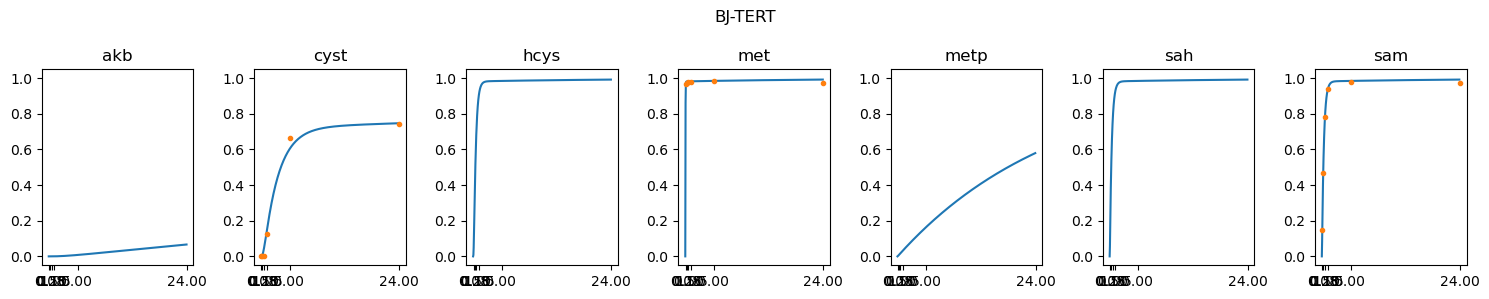

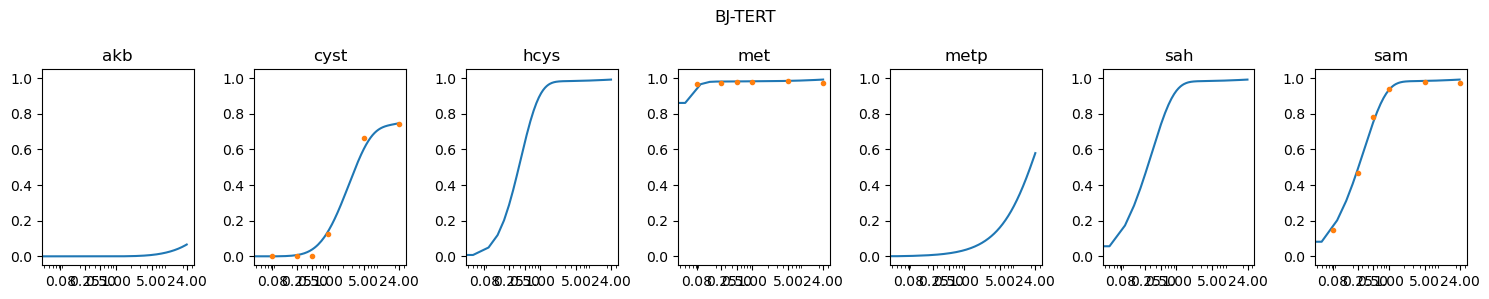

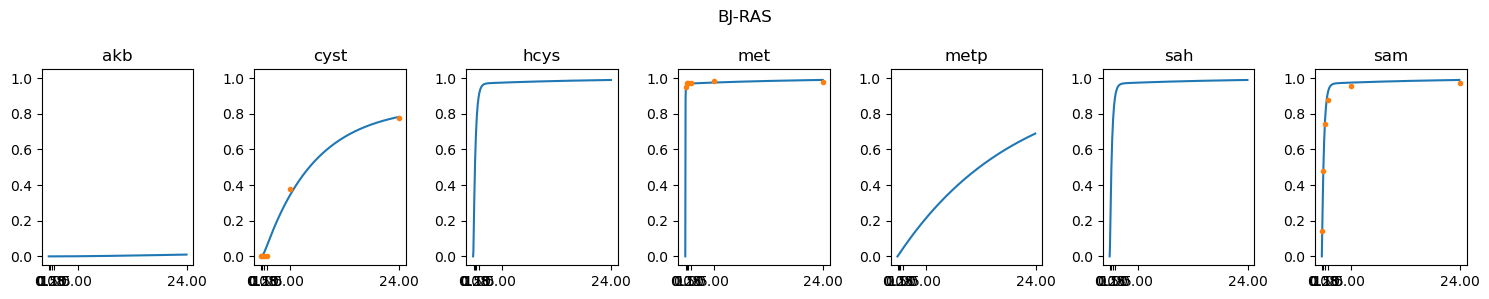

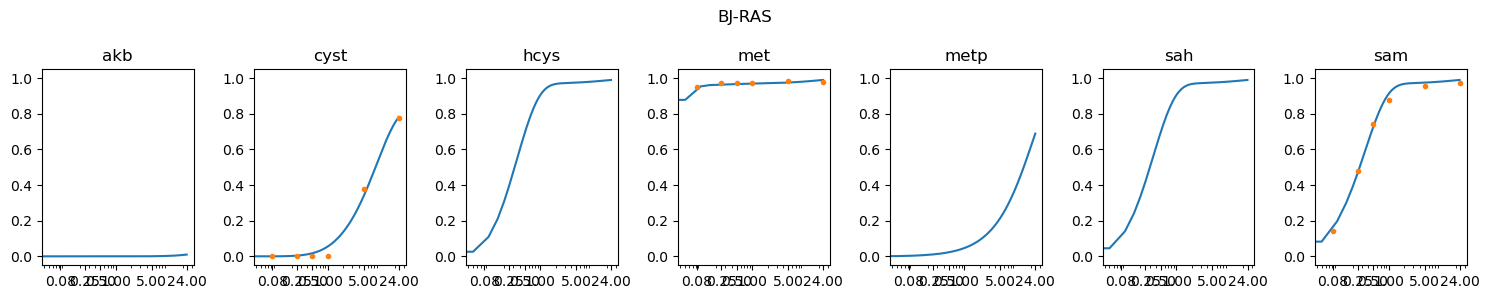

In [96]:
for cell_type in cell_types:
    for use_log_scale in [False, True]:
        plot_model_fit(
            flux_model, x_simulated.loc[cell_type], heavy_fraction_mean.loc[cell_type],
            use_log_scale=use_log_scale
        )
        plt.suptitle(cell_type)
        plt.tight_layout()
        plt.savefig(plots_path / plot_file_name(cell_type, use_log_scale))

### Confidence intervals on estimated net fluxes
These are two-sided linearized confidence intervals, based on the parameter covariance from lmfit

In [98]:
ci_reactions = ['CYSTS', 'HCYS_OUT', 'METS', 'MET_IN', 'PROT_OUT', 'SAM_METH']
ci_table = pd.concat(
    [
        prepend_index_level(
            confidence_intervals_table(flux_model, model_fits[cell_type], ci_level=0.9).loc[ci_reactions],
            cell_type, name='cell_type'
        )
        for cell_type in cell_types
    ]
)
ci_table

net     std err  ci_half-width    ci_lower  \
cell_type reaction                                                      
BJ-TERT   CYSTS       3.918462    0.734904       1.208810    2.709652   
          HCYS_OUT  149.877087   31.719494      52.173925   97.703161   
          METS       26.037927   37.608795      61.860963  -35.823036   
          MET_IN    569.383462   93.623437     153.996850  415.386611   
          PROT_OUT  415.587913   88.104056     144.918275  270.669637   
          SAM_METH  179.833476   20.072712      33.016674  146.816802   
BJ-RAS    CYSTS       0.672216    0.111653       0.183652    0.488564   
          HCYS_OUT  132.374727    5.488244       9.027358  123.347369   
          METS      203.571238   61.183321     100.637607  102.933631   
          MET_IN    641.592467  124.277554     204.418385  437.174082   
          PROT_OUT  508.545524  124.156310     204.218957  304.326567   
          SAM_METH  336.618181   60.932934     100.225758  236.392423   

                      ci_upper  
cell_type reaction              
BJ-TERT   CYSTS       5.127272  
          HCYS_OUT  202.051012  
          METS       87.898891  
          MET_IN    723.380312  
          PROT_OUT  560.506188  
          SAM_METH  212.850150  
BJ-RAS    CYSTS       0.855869  
          HCYS_OUT  141.402085  
          METS      304.208846  
          MET_IN    846.010852  
          PROT_OUT  712.764481  
          SAM_METH  436.843939

In [100]:
# since seaborn (strangely) does not support drawing error bars from specified values,
# we provide the (max, min) range as values and plot using median (midrange) and max/min for error bars
ci_table_for_seaborn = ci_table[['ci_lower', 'ci_upper']].melt(ignore_index=False).sort_index(ascending=[False, True]).reset_index()

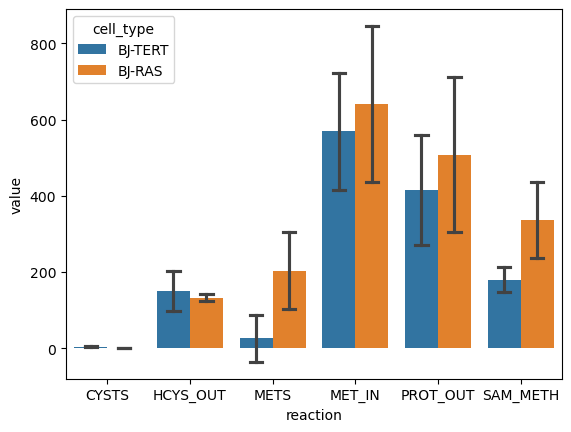

In [102]:
sns.barplot(
    ci_table_for_seaborn,
    x='reaction', y='value', hue='cell_type',
    estimator=np.median, errorbar=lambda x: [x.min(), x.max()], capsize=0.3
)
plt.savefig(plots_path / '13C-met_flux_ci.pdf')